In [2]:
import numpy as np
from optic.torchUtils import slidingWindowDataSet, MLP
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, ConcatDataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power
from optic.utils import parameters, dBm2W
from optic.models.devices import mzm, photodiode, edfa
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray

from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter
from optic.models.channels import linearFiberChannel
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
import OpticFunctions as of
import importlib
import IPython.display as ipd

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 3)

In [5]:
np.random.seed(seed=123)

In [64]:
# Parâmetros para geração de sinal
SpS = 2
Rs = 40*10**9
M = 8
num_symbs = 1e4
dist_fibra = 8

In [65]:
sinaltx, symbtx = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)

SymbTx antes da normalização:  [-7.  5.  7. ...  1.  1.  3.]


In [66]:
sinalrx = of.SimulaCanalOptico(sinal = sinaltx, SpS = SpS, Rs = Rs, dist_fibra = dist_fibra)

Number of counted errors = 10163 
BER = 3.41e-01 


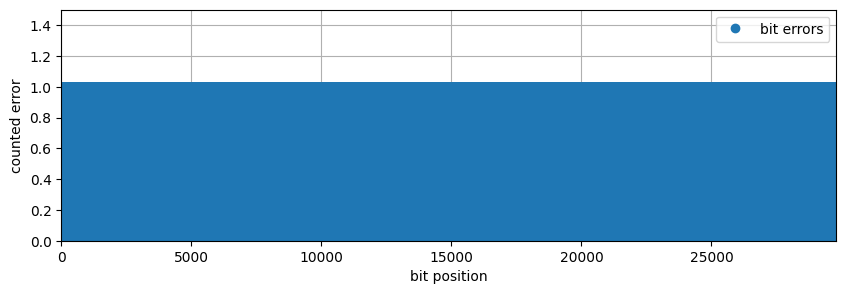

In [67]:
bits_tx = of.RecuperaBits(sinaltx, SpS, M)
bits_rx = of.RecuperaBits(sinalrx, SpS, M)
of.CalculaBER(bits_tx, bits_rx)

In [68]:
Ntaps = 2
batch_size = 100
shuffle = True
shuffle_full = False

train_dataset, test_dataset, full_dataset = of.CriaDataSet(symbtx, sinalrx, SpS, Ntaps = Ntaps)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
full_dataloader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=shuffle_full)

In [85]:
#modelo_mlp = MLP([Ntaps, 1])

In [86]:
'''loss_fn = nn.MSELoss()
epochs_mlp = 100
optimizer = torch.optim.Adam(modelo_mlp.parameters(), lr = 0.0005)
cada_print = 50

for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo_mlp, loss_fn, optimizer, cada_print)
    of.test_loop(test_dataloader, modelo_mlp, loss_fn)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)'''

Época 1
-------------------------------
loss: 1.081313[  100/ 8000]
loss: 0.948070[ 5100/ 8000]
Perda média: 0.896301 

Época 2
-------------------------------
loss: 0.956048[  100/ 8000]
loss: 0.765812[ 5100/ 8000]
Perda média: 0.812241 

Época 3
-------------------------------
loss: 0.876379[  100/ 8000]
loss: 0.745763[ 5100/ 8000]
Perda média: 0.736632 

Época 4
-------------------------------
loss: 0.689638[  100/ 8000]
loss: 0.629979[ 5100/ 8000]
Perda média: 0.668138 

Época 5
-------------------------------
loss: 0.656354[  100/ 8000]
loss: 0.663156[ 5100/ 8000]
Perda média: 0.607198 

Época 6
-------------------------------
loss: 0.527664[  100/ 8000]
loss: 0.543646[ 5100/ 8000]
Perda média: 0.552372 

Época 7
-------------------------------
loss: 0.440686[  100/ 8000]
loss: 0.470782[ 5100/ 8000]
Perda média: 0.503061 

Época 8
-------------------------------
loss: 0.504455[  100/ 8000]
loss: 0.406462[ 5100/ 8000]
Perda média: 0.459567 

Época 9
-------------------------------


Perda média: 0.193176 

Época 69
-------------------------------
loss: 0.202262[  100/ 8000]
loss: 0.218699[ 5100/ 8000]
Perda média: 0.193134 

Época 70
-------------------------------
loss: 0.163650[  100/ 8000]
loss: 0.224792[ 5100/ 8000]
Perda média: 0.193162 

Época 71
-------------------------------
loss: 0.163721[  100/ 8000]
loss: 0.218443[ 5100/ 8000]
Perda média: 0.193185 

Época 72
-------------------------------
loss: 0.175956[  100/ 8000]
loss: 0.177515[ 5100/ 8000]
Perda média: 0.193218 

Época 73
-------------------------------
loss: 0.151927[  100/ 8000]
loss: 0.180391[ 5100/ 8000]
Perda média: 0.193145 

Época 74
-------------------------------
loss: 0.211430[  100/ 8000]
loss: 0.220919[ 5100/ 8000]
Perda média: 0.193176 

Época 75
-------------------------------
loss: 0.209985[  100/ 8000]
loss: 0.174937[ 5100/ 8000]
Perda média: 0.193132 

Época 76
-------------------------------
loss: 0.242975[  100/ 8000]
loss: 0.147366[ 5100/ 8000]
Perda média: 0.193132 

Época 77

In [87]:
#torch.save(modelo_mlp, 'PrimeModel.pth')

Number of counted errors = 6862 
BER = 2.30e-01 


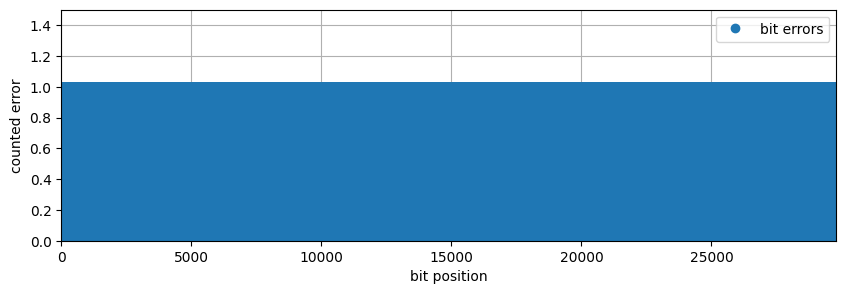

In [88]:
symb_mlp = of.GeraSinalEqualizado(modelo_mlp, full_dataloader)
const = GrayMapping(M, 'pam') 
Es = signal_power(const)
#print(symb_rx_nn.shape)
bitsrx = demodulateGray(np.sqrt(Es)*pnorm(symb_mlp), M, 'pam')
bitstx = demodulateGray(np.sqrt(Es)*pnorm(symbtx), M, 'pam')

of.CalculaBER(bitstx, bitsrx)

In [89]:
#modelo2 = MLP([Ntaps, 4, 1])

In [90]:
'''loss_fn = nn.MSELoss()
epochs2 = 100
optimizer2 = torch.optim.Adam(modelo2.parameters(), lr = 0.0005)
cada_print = 50

for t in range(epochs2):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader, modelo2, loss_fn, optimizer2, cada_print)
    of.test_loop(test_dataloader, modelo2, loss_fn)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)'''

Época 1
-------------------------------
loss: 1.012541[  100/ 8000]
loss: 1.154312[ 5100/ 8000]
Perda média: 1.099745 

Época 2
-------------------------------
loss: 1.139117[  100/ 8000]
loss: 0.843251[ 5100/ 8000]
Perda média: 1.059966 

Época 3
-------------------------------
loss: 1.021094[  100/ 8000]
loss: 0.779264[ 5100/ 8000]
Perda média: 1.018190 

Época 4
-------------------------------
loss: 0.850544[  100/ 8000]
loss: 1.095938[ 5100/ 8000]
Perda média: 0.972465 

Época 5
-------------------------------
loss: 0.957754[  100/ 8000]
loss: 0.917951[ 5100/ 8000]
Perda média: 0.924953 

Época 6
-------------------------------
loss: 0.893643[  100/ 8000]
loss: 0.771507[ 5100/ 8000]
Perda média: 0.872728 

Época 7
-------------------------------
loss: 0.707464[  100/ 8000]
loss: 0.743766[ 5100/ 8000]
Perda média: 0.815716 

Época 8
-------------------------------
loss: 0.782416[  100/ 8000]
loss: 0.781276[ 5100/ 8000]
Perda média: 0.751679 

Época 9
-------------------------------


Perda média: 0.168936 

Época 69
-------------------------------
loss: 0.138003[  100/ 8000]
loss: 0.188879[ 5100/ 8000]
Perda média: 0.168833 

Época 70
-------------------------------
loss: 0.244437[  100/ 8000]
loss: 0.125240[ 5100/ 8000]
Perda média: 0.168709 

Época 71
-------------------------------
loss: 0.201837[  100/ 8000]
loss: 0.157085[ 5100/ 8000]
Perda média: 0.168734 

Época 72
-------------------------------
loss: 0.176259[  100/ 8000]
loss: 0.143616[ 5100/ 8000]
Perda média: 0.168626 

Época 73
-------------------------------
loss: 0.149677[  100/ 8000]
loss: 0.175706[ 5100/ 8000]
Perda média: 0.168447 

Época 74
-------------------------------
loss: 0.192198[  100/ 8000]
loss: 0.202662[ 5100/ 8000]
Perda média: 0.168512 

Época 75
-------------------------------
loss: 0.144047[  100/ 8000]
loss: 0.169539[ 5100/ 8000]
Perda média: 0.168244 

Época 76
-------------------------------
loss: 0.186834[  100/ 8000]
loss: 0.163447[ 5100/ 8000]
Perda média: 0.168203 

Época 77

In [91]:
#torch.save(modelo2, 'PrimeModel2.pth')

Number of counted errors = 7044 
BER = 2.36e-01 


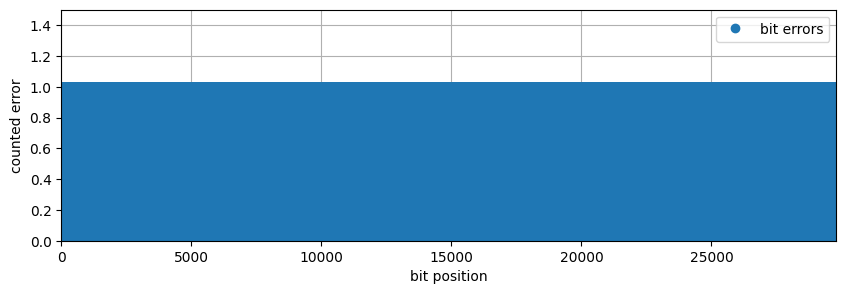

In [94]:
symb_modelo2 = of.GeraSinalEqualizado(modelo2, full_dataloader)

bitsrx2 = demodulateGray(np.sqrt(Es)*pnorm(symb_modelo2), M, 'pam')
bitstx2 = demodulateGray(np.sqrt(Es)*pnorm(symbtx), M, 'pam')

of.CalculaBER(bitstx, bitsrx)

# Treinamento das redes clone para outras distâncias de transmissão

In [92]:
sinalt4, symbt4 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)
sinalt6, symbt6 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)
sinalt10, symbt10 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)
sinalt12, symbt12 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)

SymbTx antes da normalização:  [-7. -1. -5. ...  7.  7.  3.]
SymbTx antes da normalização:  [ 1. -5. -7. ... -5. -5. -3.]
SymbTx antes da normalização:  [ 1.  1.  5. ... -5. -3. -3.]
SymbTx antes da normalização:  [ 5. -1.  3. ... -3.  7. -1.]


In [93]:
sinalr4 = of.SimulaCanalOptico(sinal = sinalt4, SpS = SpS, Rs = Rs, dist_fibra = 4)
sinalr6 = of.SimulaCanalOptico(sinal = sinalt6, SpS = SpS, Rs = Rs, dist_fibra = 6)
sinalr10 = of.SimulaCanalOptico(sinal = sinalt10, SpS = SpS, Rs = Rs, dist_fibra = 10)
sinalr12 = of.SimulaCanalOptico(sinal = sinalt12, SpS = SpS, Rs = Rs, dist_fibra = 12)

In [95]:
train_dataset4, test_dataset4, full_dataset4 = of.CriaDataSet(symbt4, sinalr4, SpS, Ntaps = Ntaps)

train_dataloader4 = DataLoader(train_dataset4, batch_size=batch_size, shuffle=shuffle)
test_dataloader4 = DataLoader(test_dataset4, batch_size=batch_size, shuffle=shuffle)
full_dataloader4 = DataLoader(full_dataset4, batch_size=len(full_dataset), shuffle=shuffle_full)


train_dataset6, test_dataset6, full_dataset6 = of.CriaDataSet(symbt6, sinalr6, SpS, Ntaps = Ntaps)

train_dataloader6 = DataLoader(train_dataset6, batch_size=batch_size, shuffle=shuffle)
test_dataloader6 = DataLoader(test_dataset6, batch_size=batch_size, shuffle=shuffle)
full_dataloader6 = DataLoader(full_dataset6, batch_size=len(full_dataset), shuffle=shuffle_full)


train_dataset10, test_dataset10, full_dataset10 = of.CriaDataSet(symbt10, sinalr10, SpS, Ntaps = Ntaps)

train_dataloader10 = DataLoader(train_dataset10, batch_size=batch_size, shuffle=shuffle)
test_dataloader10 = DataLoader(test_dataset10, batch_size=batch_size, shuffle=shuffle)
full_dataloader10 = DataLoader(full_dataset10, batch_size=len(full_dataset), shuffle=shuffle_full)


train_dataset12, test_dataset12, full_dataset12 = of.CriaDataSet(symbt12, sinalr12, SpS, Ntaps = Ntaps)

train_dataloader12 = DataLoader(train_dataset12, batch_size=batch_size, shuffle=shuffle)
test_dataloader12 = DataLoader(test_dataset12, batch_size=batch_size, shuffle=shuffle)
full_dataloader12 = DataLoader(full_dataset12, batch_size=len(full_dataset), shuffle=shuffle_full)

In [134]:
model_test = MLP([Ntaps, 1])

In [135]:
model4 = torch.load('PrimeModel.pth')

In [136]:
loss_fn = nn.MSELoss()
epochs_mlp = 7
epochs_test = 7
cada_print = 50

optimizer_test = torch.optim.Adam(model_test.parameters(),  lr = 0.0005)
optimizer4 = torch.optim.Adam(model4.parameters(), lr = 0.0005)

In [137]:
for t in range(epochs_mlp):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader4, model4, loss_fn, optimizer4, cada_print)
    of.test_loop(test_dataloader4, model4, loss_fn)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

Época 1
-------------------------------
loss: 0.038500[  100/ 8000]
loss: 0.026671[ 5100/ 8000]
Perda média: 0.031957 

Época 2
-------------------------------
loss: 0.037653[  100/ 8000]
loss: 0.025654[ 5100/ 8000]
Perda média: 0.028470 

Época 3
-------------------------------
loss: 0.024582[  100/ 8000]
loss: 0.022782[ 5100/ 8000]
Perda média: 0.027579 

Época 4
-------------------------------
loss: 0.026638[  100/ 8000]
loss: 0.027048[ 5100/ 8000]
Perda média: 0.027411 

Época 5
-------------------------------
loss: 0.024546[  100/ 8000]
loss: 0.031489[ 5100/ 8000]
Perda média: 0.027369 

Época 6
-------------------------------
loss: 0.029541[  100/ 8000]
loss: 0.028390[ 5100/ 8000]
Perda média: 0.027282 

Época 7
-------------------------------
loss: 0.026531[  100/ 8000]
loss: 0.026292[ 5100/ 8000]
Perda média: 0.027231 

Pronto!


In [138]:
for t in range(epochs_test):
    print(f"Época {t+1}\n-------------------------------")
    of.train_loop(train_dataloader4, model_test, loss_fn, optimizer_test, cada_print)
    of.test_loop(test_dataloader4, model_test, loss_fn)
print("Pronto!")

framerate = 44100
t = np.linspace(0,1,framerate*1)
data = np.sin(2*np.pi*220*t) + np.sin(2*np.pi*224*t)
ipd.Audio(data,rate=framerate, autoplay=True)

Época 1
-------------------------------
loss: 2.430954[  100/ 8000]
loss: 2.170262[ 5100/ 8000]
Perda média: 2.014697 

Época 2
-------------------------------
loss: 1.921376[  100/ 8000]
loss: 1.852720[ 5100/ 8000]
Perda média: 1.855728 

Época 3
-------------------------------
loss: 1.819678[  100/ 8000]
loss: 1.718373[ 5100/ 8000]
Perda média: 1.707127 

Época 4
-------------------------------
loss: 1.474009[  100/ 8000]
loss: 1.457619[ 5100/ 8000]
Perda média: 1.567945 

Época 5
-------------------------------
loss: 1.424827[  100/ 8000]
loss: 1.328290[ 5100/ 8000]
Perda média: 1.438471 

Época 6
-------------------------------
loss: 1.625918[  100/ 8000]
loss: 1.083851[ 5100/ 8000]
Perda média: 1.318472 

Época 7
-------------------------------
loss: 1.204389[  100/ 8000]
loss: 1.331100[ 5100/ 8000]
Perda média: 1.206910 

Pronto!


In [139]:
discard = 100
power = np.arange(-15, 0)
BER4 = np.zeros(power.size)
BER_NN4 = np.zeros(power.size)
BER_NNC4 = np.zeros(power.size)
SpS_out = 1
Ntaps = 2

for ind, Pin in enumerate(power):
    sinaltx4, symbtx4 = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, Pi_dBm = Pin, num_symbs = 1e5)
    
    irx4 = of.SimulaCanalOptico(sinaltx4, SpS = SpS, Rs = Rs, dist_fibra = 4)
    
    bitsTx4 = of.RecuperaBits(sinaltx4, SpS, M)
    bitsRx4 = of.RecuperaBits(irx4, SpS, M)
    
    err = np.logical_xor(bitsRx4[discard:bitsRx4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER4[ind] = np.mean(err)
    
    print('BER = %.2e '%(BER4[ind]))
    
    signalrx4 = pnorm(irx4[0::SpS//SpS_out])
    signalrx4= (signalrx4 - np.mean(signalrx4))/np.std(signalrx4)
    
    dataset4 = slidingWindowDataSet(signalrx4, symbtx4, Ntaps, SpS_out)
    
    dataloader4 = DataLoader(dataset4, batch_size=len(dataset4), shuffle=False)

    symb_NN4 = of.GeraSinalEqualizado(model_test, dataloader4)

    bitsRxNN4 = demodulateGray(np.sqrt(Es)*pnorm(symb_NN4), M, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRxNN4[discard:bitsRxNN4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER_NN4[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NN4[ind]))
    
    symb_NNC4 = of.GeraSinalEqualizado(model4, dataloader4)
    
    bitsRxNNC4 = demodulateGray(np.sqrt(Es)*pnorm(symb_NNC4), M, 'pam')

    #discard = 1000
    err = np.logical_xor(bitsRxNNC4[discard:bitsRxNNC4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER_NNC4[ind] = np.mean(err)

    #Pb = 0.5*erfc(Q/np.sqrt(2)) # theoretical error probability
    print('BER_NN = %.2e '%(BER_NNC4[ind]))

SymbTx antes da normalização:  [-7.  7. -3. ... -5. -5.  7.]
BER = 2.69e-01 
BER_NN = 4.90e-01 
BER_NN = 2.35e-01 
SymbTx antes da normalização:  [-5.  1.  5. ... -7.  5. -5.]
BER = 2.50e-01 
BER_NN = 4.90e-01 
BER_NN = 2.02e-01 
SymbTx antes da normalização:  [-1. -3. -5. ...  7.  1. -3.]
BER = 2.33e-01 
BER_NN = 4.89e-01 
BER_NN = 1.73e-01 
SymbTx antes da normalização:  [ 7. -5.  1. ...  1. -1. -5.]
BER = 2.23e-01 
BER_NN = 4.90e-01 
BER_NN = 1.48e-01 
SymbTx antes da normalização:  [ 3.  7. -3. ...  7.  3. -5.]
BER = 2.15e-01 
BER_NN = 4.89e-01 
BER_NN = 1.29e-01 
SymbTx antes da normalização:  [ 7.  5. -5. ... -7.  7. -1.]
BER = 2.12e-01 
BER_NN = 4.90e-01 
BER_NN = 1.14e-01 
SymbTx antes da normalização:  [-5. -3.  5. ...  1. -5. -3.]
BER = 2.08e-01 
BER_NN = 4.90e-01 
BER_NN = 1.03e-01 
SymbTx antes da normalização:  [-3. -3.  7. ... -7. -5.  7.]
BER = 2.06e-01 
BER_NN = 4.90e-01 
BER_NN = 9.33e-02 
SymbTx antes da normalização:  [ 5. -3. -5. ...  5.  7.  7.]
BER = 2.06e-01 
BER

Text(0, 0.5, 'log10(BER)')

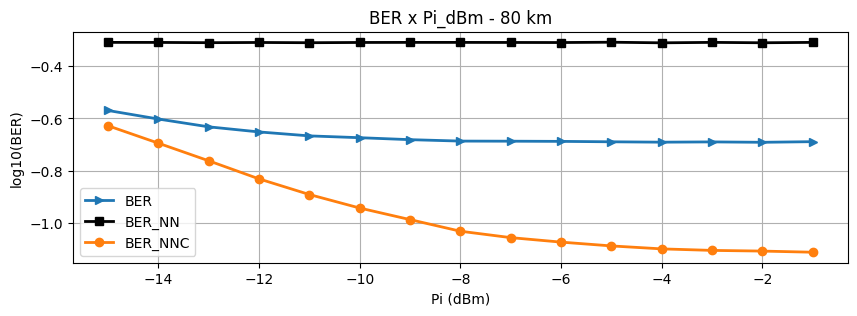

In [140]:
plt.plot(power, np.log10(BER4),'>-', label='BER',linewidth = 2)
plt.plot(power, np.log10(BER_NN4),'-s', label='BER_NN', color = 'black', linewidth = 2)
plt.plot(power, np.log10(BER_NNC4), '-o', label = 'BER_NNC', linewidth = 2)
plt.grid()
plt.legend();
plt.title('BER x Pi_dBm - 80 km')
plt.xlabel('Pi (dBm)')
plt.ylabel('log10(BER)')